**Segmentation using Customer Lifetime Value (CLV) Method**

# Business Background

The origin concept of Customer Lifetime Value (CLV) is used when companies would like to analyze the customer buying behavior and maximize the value of the transaction with the customer. CLV is the aggregate worth to a company of a user throughout his/her customer relationships. It is an imperative metric as it charges less to keep the existing customers than it does to attain new ones, so mounting the worth of our present customers is a great method to attract growth.

# Objective

This study aimed to:
* Identify the dimensions and indicators of the lifetime value of online retail customers
* Establish a customer segmentation using K-Means Clustering
* Create a Customer Relationship Management (CRM) strategy

# Data Collection

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from yellowbrick.cluster import KElbowVisualizer

numpy version :  1.21.6
pandas version :  1.3.5
seaborn version :  0.11.2


In [2]:
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

In [3]:
data = pd.read_excel('/content/sample_data/online_retail_II.xlsx')
#data = data.dropna()
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Data Understanding

This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   CustomerID   406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


* InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
* StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
* Description: Product (item) name. Nominal.
* Quantity: The quantities of each product (item) per transaction. Numeric.
* InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.
* UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£).
* CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
* Country: Country name. Nominal. The name of the country where a customer resides.

In [5]:
data.iloc[12]

Invoice                              536368
StockCode                             22914
Description    BLUE COAT RACK PARIS FASHION
Quantity                                  3
InvoiceDate             2010-12-01 08:34:00
Price                                  4.95
CustomerID                          13047.0
Country                      United Kingdom
Name: 12, dtype: object

# Data Preprocessing

## Duplicate Values

In [6]:
data.duplicated().sum()

5268

In [7]:
print(f"Data Frame Dimension Before Duplicate Removal: {data.shape}")
data = data.drop_duplicates()
print(f"Data Frame Dimension After Duplicate Removal: {data.shape}")

Data Frame Dimension Before Duplicate Removal: (541910, 8)
Data Frame Dimension After Duplicate Removal: (536642, 8)


## Check Null and Missing Values

In [8]:
data_null = data.isnull().sum().reset_index()
data_null.columns = ['feature','missing_value']
data_null['percentage'] = round((data_null['missing_value']/len(data))*100,2)
data_null = data_null.sort_values('percentage', ascending=False).reset_index(drop=True)
data_null = data_null[data_null['percentage']>0]
data_null

,feature,missing_value,percentage
0,CustomerID,135037,25.16
1,Description,1454,0.27


In [9]:
print(f"Data Frame Dimension Before Missing Value Removal: {data.shape}")
data = data.dropna()
print(f"Data Frame Dimension After Missing Value Removal: {data.shape}")

Data Frame Dimension Before Missing Value Removal: (536642, 8)
Data Frame Dimension After Missing Value Removal: (401605, 8)


## Statistical Summary

In [10]:
data.describe()

,Quantity,Price,CustomerID
count,401605.000000,401605.000000,401605.000000
mean,12.183245,3.474100,15281.154341
std,250.282726,69.763952,1714.008869
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


`Quantity` value should be greater than zero. So we decide to drop rows which has `Quantity` < 0

In [11]:
print(f"Data Frame Dimension Before Removal: {data.shape}")
data = data[(data['Quantity'] > 0)]
print(f"Data Frame Dimension After Removal: {data.shape}")

Data Frame Dimension Before Removal: (401605, 8)
Data Frame Dimension After Removal: (392733, 8)


## Numeric Distribution and oulier

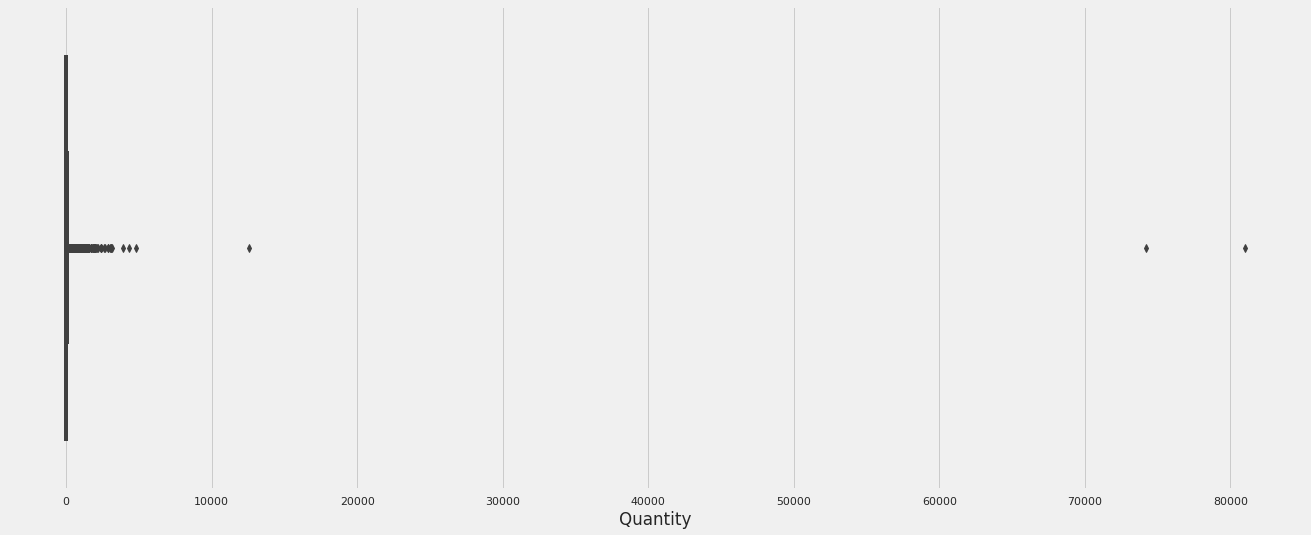

In [12]:
sns.boxplot(data = data
            ,x = 'Quantity'
            )

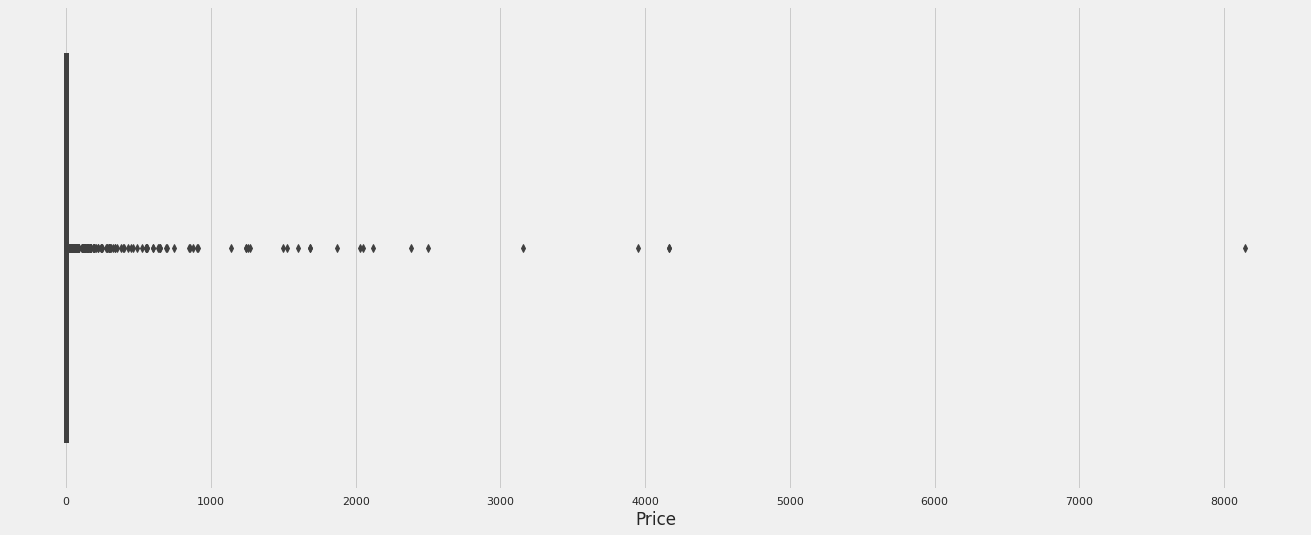

In [13]:
sns.boxplot(data = data
            ,x = 'Price'
            )

In [14]:
print(f"Data Frame Dimension Before IQR Removal: {data.shape}")

# IQR Calculation and its boundary
Q1_Quantity = data["Quantity"].quantile(0.25)
Q3_Quantity = data["Quantity"].quantile(0.75)
IQR_Quantity = Q3_Quantity - Q1_Quantity
lower_boundary_Quantity = Q1_Quantity - (1.5 * IQR_Quantity)
upper_boundary_Quantity = Q3_Quantity + (1.5 * IQR_Quantity)

Q1_Price = data["Price"].quantile(0.25)
Q3_Price = data["Price"].quantile(0.75)
IQR_Price = Q3_Price - Q1_Price
lower_boundary_Price = Q1_Price - (1.5 * IQR_Price)
upper_boundary_Price = Q3_Price + (1.5 * IQR_Price)

# Create filter logic of IQR
filter_logic_Quantity = (data["Quantity"] >= lower_boundary_Quantity) & (data["Quantity"] <= upper_boundary_Quantity)
filter_logic_Price = (data["Price"] >= lower_boundary_Price) & (data["Price"] <= upper_boundary_Price)

# Apply the filter
data = data[filter_logic_Quantity]
data = data[filter_logic_Price]

print(f"Data Frame Dimension After IQR Removal: {data.shape}")

Data Frame Dimension Before IQR Removal: (392733, 8)
Data Frame Dimension After IQR Removal: (333265, 8)


## Data Exploration

Top 5 Products which have most number of orders

In [15]:
product = data.groupby(by=["StockCode","Description"], as_index=False)["Invoice"].count()

top5order = product.sort_values(by="Invoice", ascending=False).head(5)
top5order

,StockCode,Description,Invoice
3328,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1668
3321,85099B,JUMBO BAG RED RETROSPOT,1327
2415,47566,PARTY BUNTING,1268
97,20725,LUNCH BAG RED RETROSPOT,1195
2602,84879,ASSORTED COLOUR BIRD ORNAMENT,1146


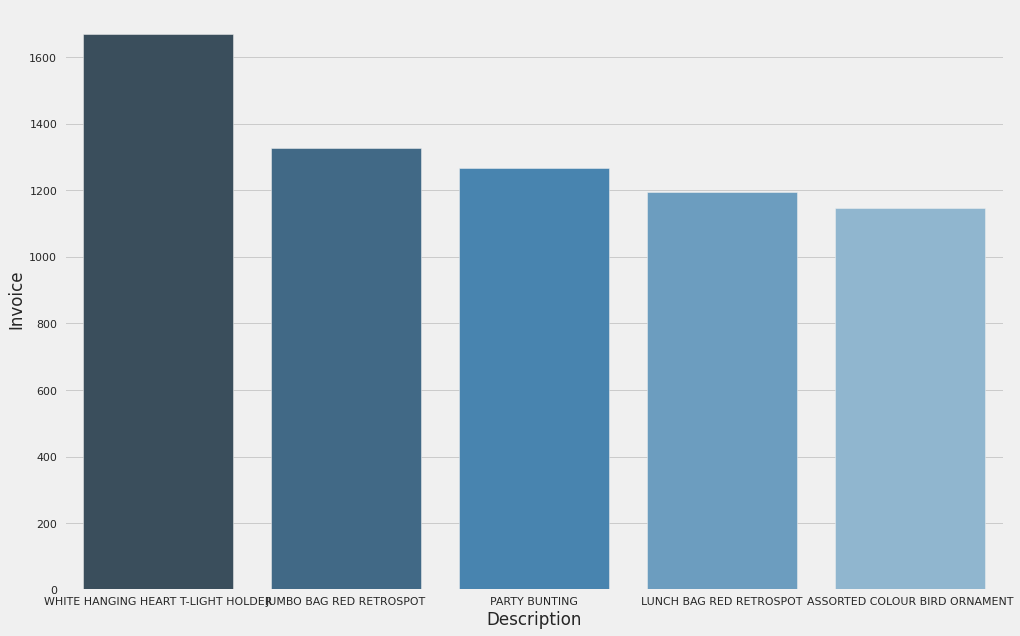

In [16]:
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(x = 'Description',y='Invoice',data=top5order,ax=ax,
               palette=reversed(sns.color_palette("Blues_d", n_colors=5))
               )

Top 5 Customers who have most number of orders and its country

In [17]:
orders = data.groupby(by=["CustomerID","Country"], as_index=False)["Invoice"].count()

top5cust = orders.sort_values(by="Invoice", ascending=False).head(5)
top5cust

,CustomerID,Country,Invoice
3892,17841.0,United Kingdom,7209
1835,14911.0,EIRE,4488
1258,14096.0,United Kingdom,4415
330,12748.0,United Kingdom,4047
1621,14606.0,United Kingdom,2425


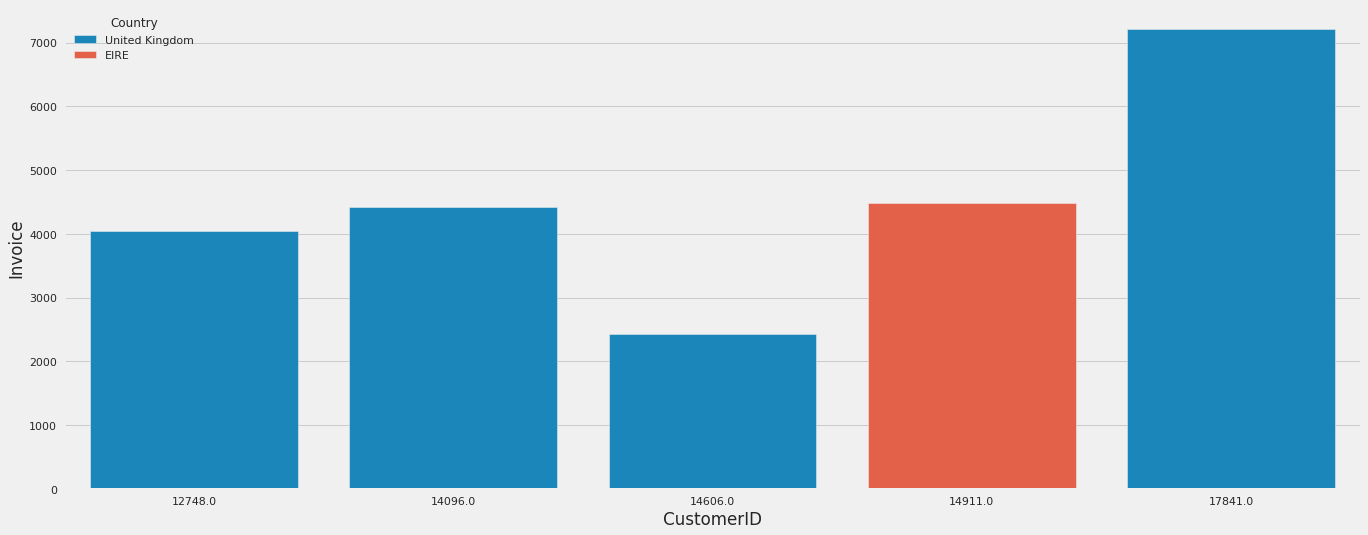

In [18]:
sns.barplot(x="CustomerID", y="Invoice", hue="Country",
                 data=top5cust, dodge=False)

Order Quantity per Day

In [19]:
# Add the column Day for the invoice
# +1 to make Monday = 1.....until Sunday = 7

data.insert(loc=5, column='Day', value=(data.InvoiceDate.dt.dayofweek)+1)
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Day,Price,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,3,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,3,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3,3.39,17850.0,United Kingdom


In [20]:
OrderDay = data.groupby(by=["Day"], as_index=False)["Invoice"].count()
OrderDay

,Day,Invoice
0,1,54609
1,2,55374
2,3,56838
3,4,66124
4,5,45868
5,7,54452


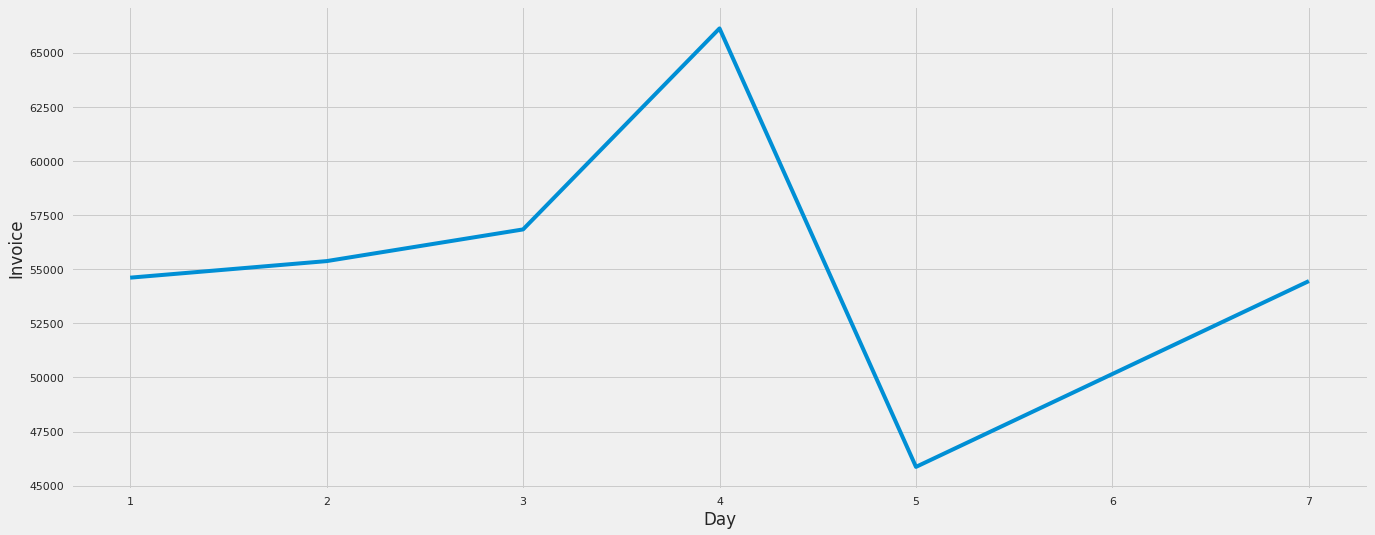

In [21]:
sns.lineplot(x = 'Day', y = 'Invoice', data = OrderDay)

## Feature Selection

First of all, since the letter "C" indicates the cancelation the values which do not contains "C" in the invoice code are selected.

In [22]:
print(f"Data Frame Dimension Before C Removal: {data.shape}")

data = data[~data["Invoice"].astype(str).str.contains("C", na=False)]

print(f"Data Frame Dimension After C Removal: {data.shape}")

Data Frame Dimension Before C Removal: (333265, 9)
Data Frame Dimension After C Removal: (333265, 9)


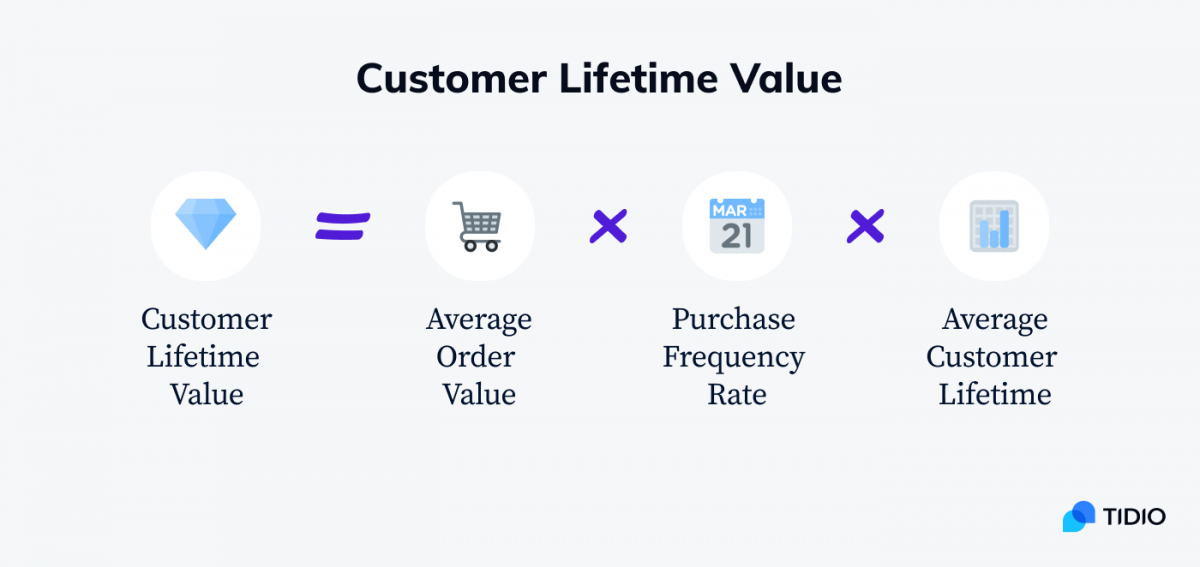

In [23]:
data["TotalPrice"] = data["Quantity"] * data["Price"]
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Day,Price,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,3,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,3,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3,3.39,17850.0,United Kingdom,20.34


In [24]:
data.InvoiceDate.max()

Timestamp('2011-12-09 12:50:00')

as today's date it will be taken 2 days after the last date in the dataset

In [25]:
today_date = dt.datetime(2011, 12, 11)

* Avg_Order_Value: Average dollar amount of a purchase
* Purchase_Freq: Number of customer purchase
* Cust_Lifespan: Average length of the customer relationship



In [26]:
cltv_df=data.groupby("CustomerID").agg(({"InvoiceDate":[lambda x:(x.max()-x.min()).days],
        "Invoice":lambda x:x.nunique(),
        "TotalPrice":lambda x:x.sum()}))
cltv_df.head()

,InvoiceDate,Invoice,TotalPrice
,<lambda>,<lambda>,<lambda>
CustomerID,,,
12347.0,365,7,3314.73
12348.0,109,3,90.20
12349.0,0,1,999.15
12350.0,0,1,294.40
12352.0,260,7,1130.94


In [27]:
{cltv_df.shape}

{(4192, 3)}

In [28]:
cltv_df.columns = cltv_df.columns.droplevel(0)

## Naming the Features
cltv_df.columns=["Cust_Lifespan","Purchase_Frequency","Sum_Order_Value"]
cltv_df.head()

,Cust_Lifespan,Purchase_Frequency,Sum_Order_Value
CustomerID,,,
12347.0,365,7,3314.73
12348.0,109,3,90.20
12349.0,0,1,999.15
12350.0,0,1,294.40
12352.0,260,7,1130.94


Average amount of a purchase (`Avg_Order_Value`) need to be calculated.

In [29]:
cltv_df["Avg_Order_Value"]=cltv_df["Sum_Order_Value"] / cltv_df["Purchase_Frequency"]
cltv_df.drop("Sum_Order_Value", axis = 1, inplace = True)
cltv_df.head()

,Cust_Lifespan,Purchase_Frequency,Avg_Order_Value
CustomerID,,,
12347.0,365,7,473.532857
12348.0,109,3,30.066667
12349.0,0,1,999.150000
12350.0,0,1,294.400000
12352.0,260,7,161.562857


## Correlation Matrix

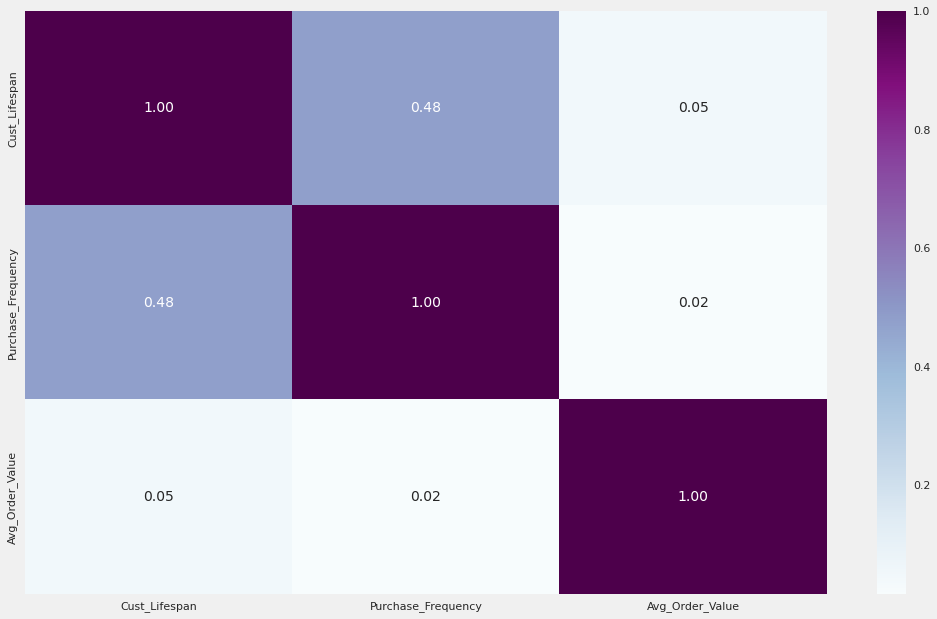

In [30]:
corr_= cltv_df.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_, annot=True, fmt = ".2f", cmap = "BuPu")

## Scaling

In [31]:
CLV = cltv_df.reset_index()
CLV = CLV[['Cust_Lifespan','Purchase_Frequency','Avg_Order_Value']]
CLV.head()

,Cust_Lifespan,Purchase_Frequency,Avg_Order_Value
0,365,7,473.532857
1,109,3,30.066667
2,0,1,999.150000
3,0,1,294.400000
4,260,7,161.562857


In [32]:
data_CLV_std = StandardScaler().fit_transform(CLV)
scaled_data_CLV = pd.DataFrame(data_CLV_std, columns=list(CLV))
scaled_data_CLV.head()

,Cust_Lifespan,Purchase_Frequency,Avg_Order_Value
0,1.799535,0.424948,1.056697
1,-0.148704,-0.144684,-1.035940
2,-0.978228,-0.429500,3.536990
3,-0.978228,-0.429500,0.211402
4,1.000453,0.424948,-0.415433


# Modeling

## Find the Best K

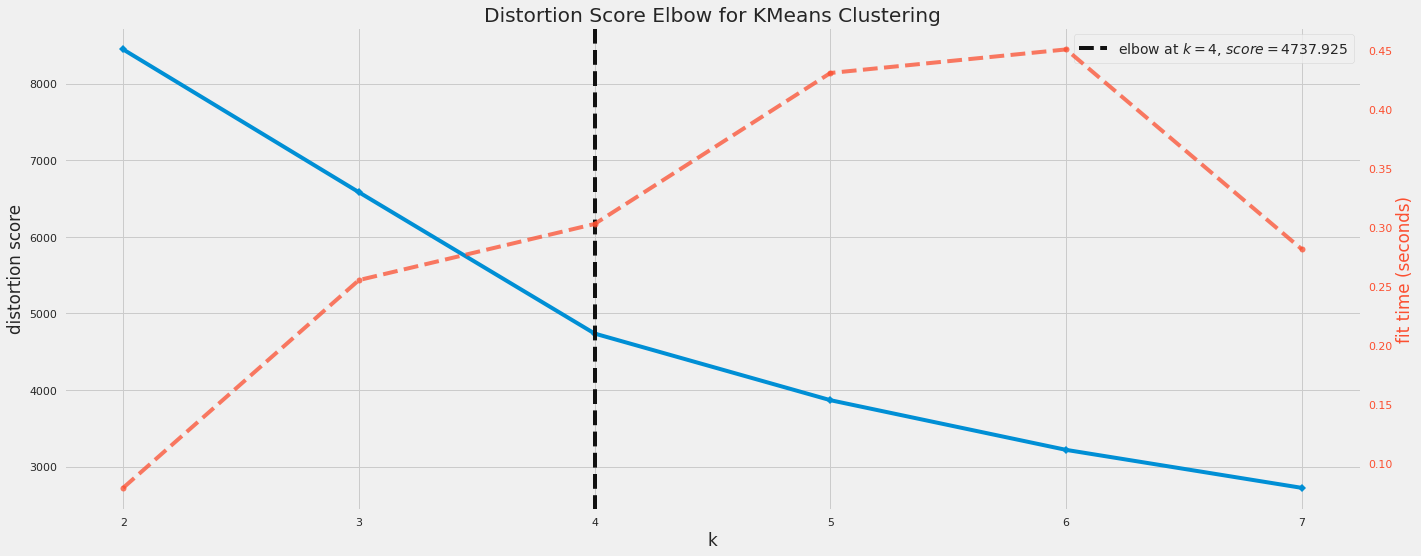

4

In [33]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans,k=(2, 8))
elbow.fit(scaled_data_CLV)
elbow.show()

elbow.elbow_value_

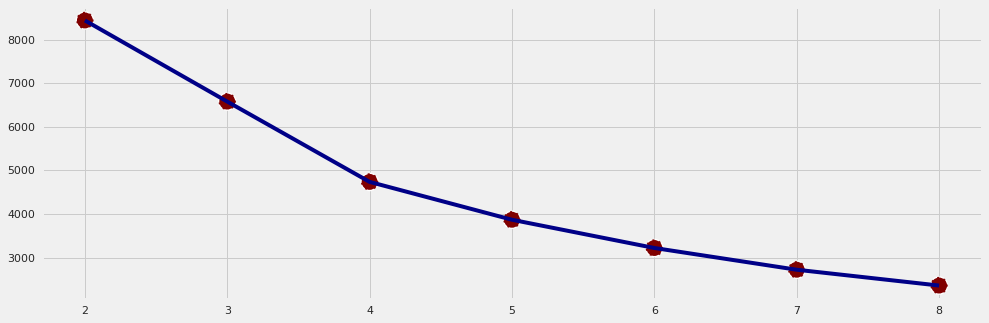

In [34]:
arr_inertia = []
for i in range(2,9):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(scaled_data_CLV)
    arr_inertia.append(kmeans.inertia_) # Sum of squared distances of samples to their closest cluster center.
    
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x=range(2,9), y=arr_inertia, color='#000087', linewidth = 4)
sns.scatterplot(x=range(2,9), y=arr_inertia, s=300, color='#800000',  linestyle='--')

## Clustering

In [35]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(scaled_data_CLV)
scaled_data_CLV['cluster'] = kmeans.labels_
CLV['cluster'] = kmeans.labels_

In [36]:
CLV

,Cust_Lifespan,Purchase_Frequency,Avg_Order_Value,cluster
0,365,7,473.532857,3
1,109,3,30.066667,1
2,0,1,999.150000,0
3,0,1,294.400000,1
4,260,7,161.562857,3
...,...,...,...,...
4187,0,1,137.000000,1
4188,0,1,46.920000,1
4189,118,2,56.565000,1
4190,333,16,125.164375,3


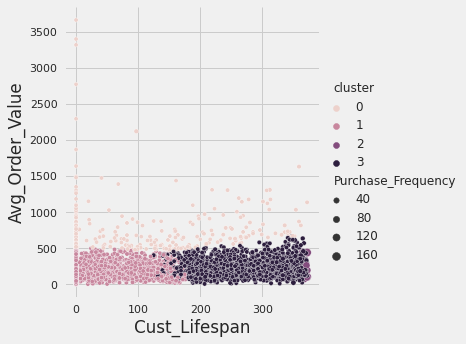

In [37]:
sns.relplot(data=CLV, x='Cust_Lifespan', y='Avg_Order_Value', size='Purchase_Frequency', hue="cluster")

## Clustering Visualization

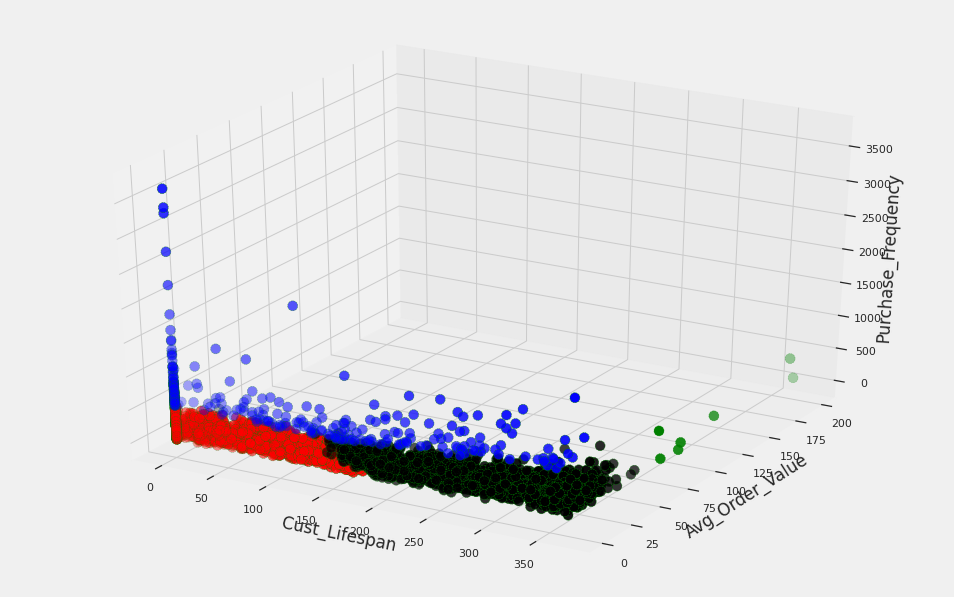

In [39]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(CLV.Cust_Lifespan[CLV.cluster == 0], CLV["Purchase_Frequency"][CLV.cluster == 0], CLV["Avg_Order_Value"][CLV.cluster == 0], c='blue', s=100, edgecolor='green',linestyle='--')
ax.scatter(CLV.Cust_Lifespan[CLV.cluster == 1], CLV["Purchase_Frequency"][CLV.cluster == 1], CLV["Avg_Order_Value"][CLV.cluster == 1], c='red', s=100, edgecolor='green',linestyle='--')
ax.scatter(CLV.Cust_Lifespan[CLV.cluster == 2], CLV["Purchase_Frequency"][CLV.cluster == 2], CLV["Avg_Order_Value"][CLV.cluster == 2], c='green', s=100, edgecolor='green',linestyle='--')
ax.scatter(CLV.Cust_Lifespan[CLV.cluster == 3], CLV["Purchase_Frequency"][CLV.cluster == 3], CLV["Avg_Order_Value"][CLV.cluster == 3], c='black', s=100, edgecolor='green',linestyle='--')


plt.xlabel("Cust_Lifespan")
plt.ylabel("Avg_Order_Value")
ax.set_zlabel("Purchase_Frequency")
plt.show()

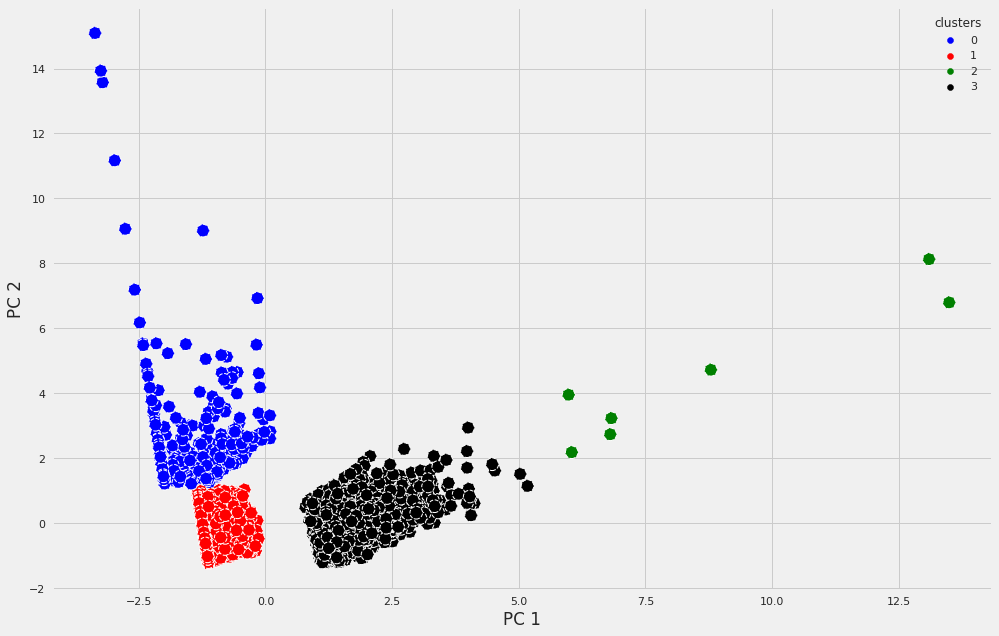

In [40]:
pca = PCA(n_components=2)

pca.fit(scaled_data_CLV)
pcs = pca.transform(scaled_data_CLV)

data_pca = pd.DataFrame(data = pcs, columns = ['PC 1', 'PC 2'])
data_pca['clusters'] = kmeans.labels_

fig, ax = plt.subplots(figsize=(15,10))

sns.scatterplot(
    x="PC 1", y="PC 2",
    hue="clusters",
    edgecolor='white',
    linestyle='--',
    data=data_pca,
    palette=['blue','red','green','black'],
    s=160,
    ax=ax
)


# Insight - Analysis Clustering

## Cluster Distribution

In [41]:
cluster_distribution = CLV['cluster'].value_counts().reset_index()
cluster_distribution.columns = ['cluster','number of users']
cluster_distribution

,cluster,number of users
0,1,2322
1,3,1567
2,0,296
3,2,7


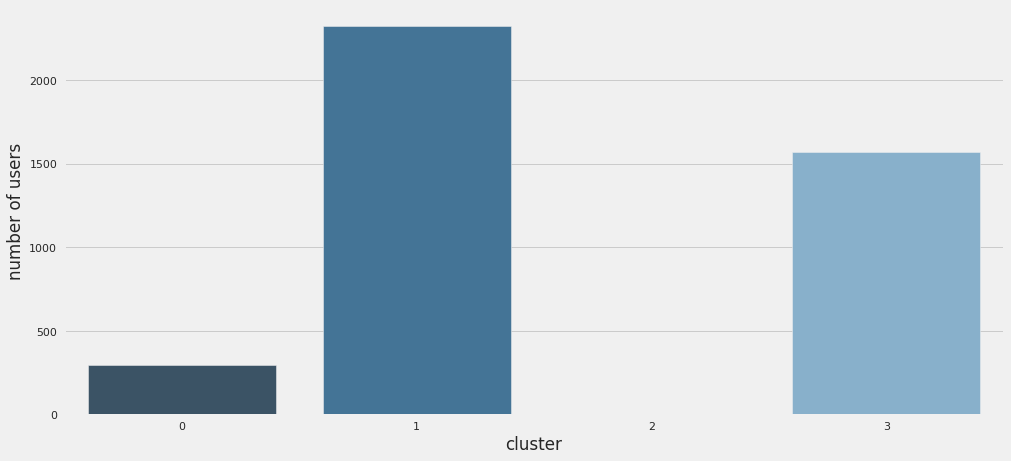

In [42]:
fig, ax = plt.subplots(figsize=(15,7))

g = sns.barplot(x = 'cluster',y='number of users',data=cluster_distribution,ax=ax,palette=reversed(sns.color_palette("Blues_d", n_colors=4)))

x = np.arange(len(cluster_distribution['cluster']))
y = cluster_distribution['number of users']

## Cluster Characteristic

In [43]:
CLV['Cluster'] = CLV['cluster']
CLV

,Cust_Lifespan,Purchase_Frequency,Avg_Order_Value,cluster,Cluster
0,365,7,473.532857,3,3
1,109,3,30.066667,1,1
2,0,1,999.150000,0,0
3,0,1,294.400000,1,1
4,260,7,161.562857,3,3
...,...,...,...,...,...
4187,0,1,137.000000,1,1
4188,0,1,46.920000,1,1
4189,118,2,56.565000,1,1
4190,333,16,125.164375,3,3


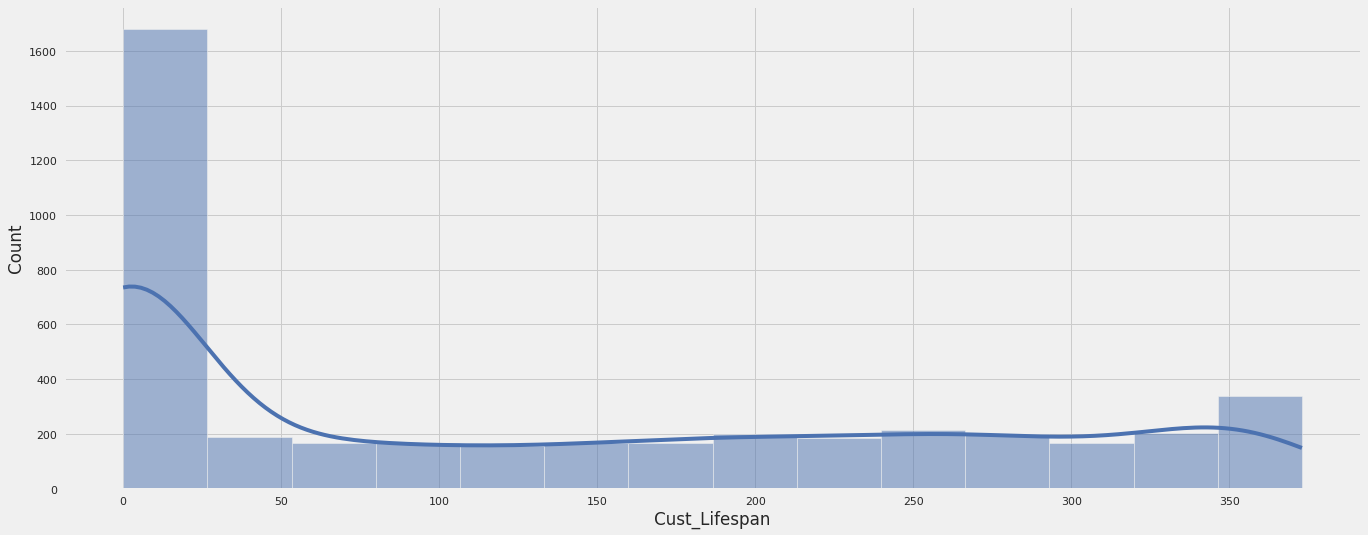

In [44]:
sns.histplot(data=CLV, x="Cust_Lifespan", kde=True)

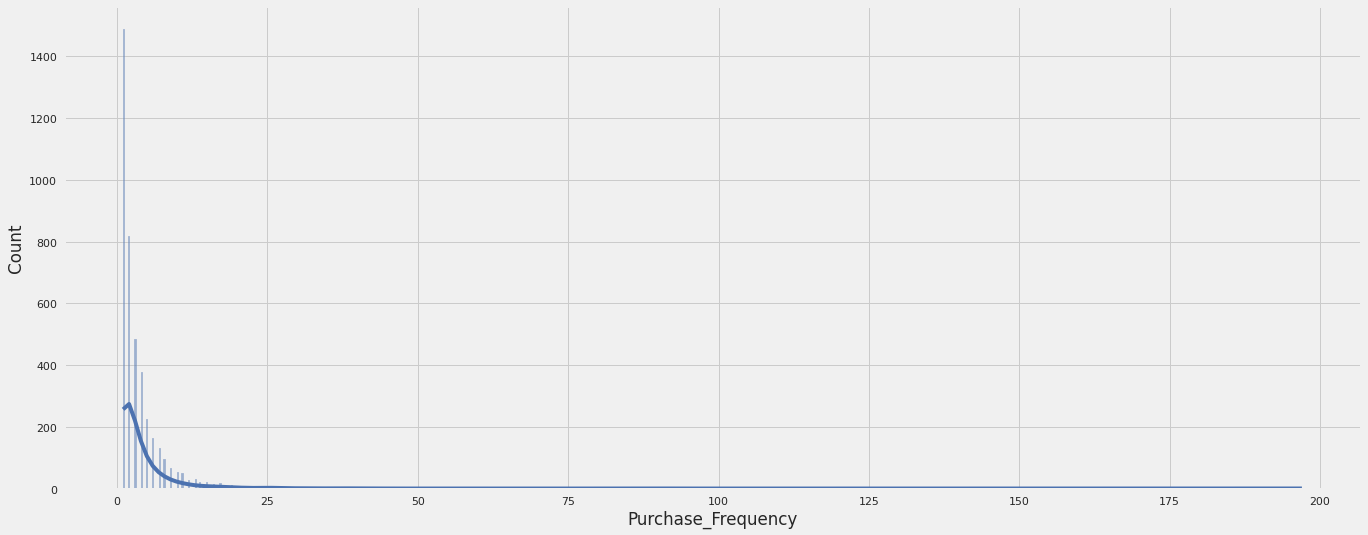

In [45]:
sns.histplot(data=CLV, x="Purchase_Frequency", kde=True)

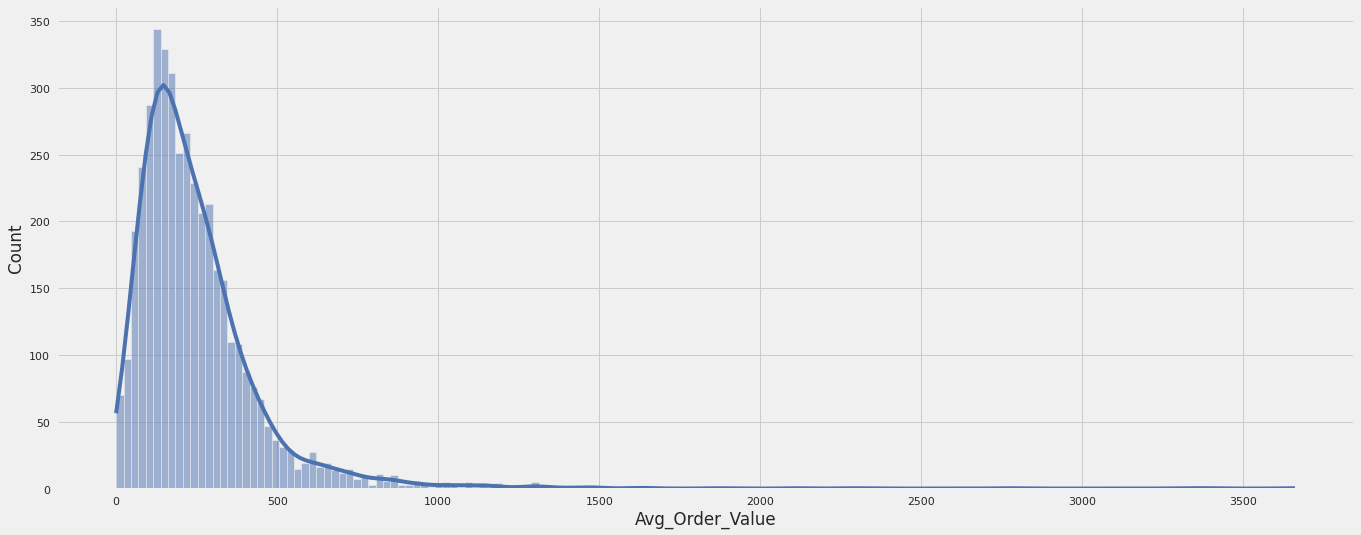

In [46]:
sns.histplot(data=CLV, x="Avg_Order_Value", kde=True)

We will use median to interpret customer characteristic

In [47]:
ClusterChara=CLV.groupby("cluster").agg(({"Cust_Lifespan":[lambda x:x.median()],
        "Purchase_Frequency":lambda x:x.median(),
        "Avg_Order_Value":lambda x:x.median(),
        "Cluster": lambda x:x.count()}))
ClusterChara.head()

,Cust_Lifespan,Purchase_Frequency,Avg_Order_Value,Cluster
,<lambda>,<lambda>,<lambda>,<lambda>
cluster,,,,
0,75.0,2.0,667.668333,296
1,0.0,1.0,171.185000,2322
2,372.0,91.0,194.647912,7
3,276.0,5.0,217.002000,1567


In [48]:
ClusterChara = ClusterChara.reset_index()

## Naming the Features
ClusterChara.columns=["Cluster","Cust_Lifespan(Median)","Purchase_Frequency(Median)","Avg_Order_Value(Median)","Number_of_User"]
ClusterChara

,Cluster,Cust_Lifespan(Median),Purchase_Frequency(Median),Avg_Order_Value(Median),Number_of_User
0,0,75.0,2.0,667.668333,296
1,1,0.0,1.0,171.185000,2322
2,2,372.0,91.0,194.647912,7
3,3,276.0,5.0,217.002000,1567
